In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

from utils import build_vocab, compute_roc_auc_splits
from models import RecurrentModel, VanillaRNNBlock, GRUBlock, LSTMBlock
from nameTrainer import NameTrainer

# Загрузка и анализ данных (#2)

In [3]:
df = pd.read_csv(r'data/babynames-clean.csv', header=None)
df.columns = ['name', "gender"]

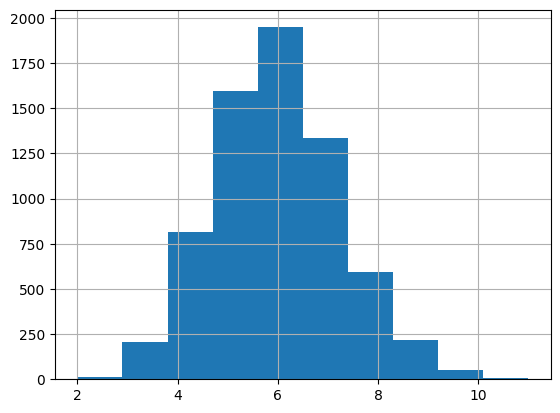

In [17]:
df.name.str.len().hist();

In [6]:
df.gender.value_counts()/df.shape[0]*100

gender
boy     50.678266
girl    49.321734
Name: count, dtype: float64

In [4]:
cleaned = df.name.str.strip()
cleaned = df.name.str.lower()

In [13]:
cleaned.str.split("").explode().value_counts()

name
     13564
a     5593
e     5038
n     3524
i     3264
l     3255
r     3070
o     2071
t     1745
s     1674
d     1532
m     1245
y     1243
h     1206
c     1063
u      707
b      673
k      616
g      526
j      502
v      490
f      302
w      271
p      265
z      199
x       71
q       61
Name: count, dtype: int64

# Подготовка данных (№3)

In [5]:
df.gender = (df.gender == "boy")*1

In [6]:
with_tokens = [f"<{name}>" for name in cleaned]
max_len = max(len(s) for s in with_tokens)
padded = [s.ljust(max_len, ' ') for s in with_tokens]

In [7]:
max_len

13

In [7]:
tokens, token2id, id2token = build_vocab(padded)

In [8]:
encoded = np.zeros((len(padded), max_len), dtype=np.int64)
    
for i, name in enumerate(padded):
    encoded[i] = [token2id[ch] for ch in name]

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(
    encoded, df.gender, test_size=0.2, random_state=42, stratify=df.gender
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [10]:
X_train_t = torch.from_numpy(X_train).long()
X_valid_t = torch.from_numpy(X_valid).long()
X_test_t  = torch.from_numpy(X_test).long()

y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
y_valid_t = torch.tensor(y_valid.values, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
valid_dataset = TensorDataset(X_valid_t, y_valid_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)

In [11]:
BATCH_SIZE = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Vanilla RNN (№4)

In [15]:
model = RecurrentModel(
    vocab_size=len(tokens),
    embedding_dim=64,
    hidden_size=128,
    rnn_block_cls=VanillaRNNBlock,
    dropout_p=0.1,
)

## Генерация имен

In [ ]:
trainer_next = NameTrainer(
    model,
    use_next_char_loss=True,
    use_gender_loss=False,
    alpha=1.0,
    beta=0.0,
)

Epoch 1: train_next=1.0269, valid_next=1.1647
Epoch 10: train_next=1.0244, valid_next=1.1639
Epoch 20: train_next=1.0244, valid_next=1.1665
Epoch 25: train_next=1.0213, valid_next=1.1696


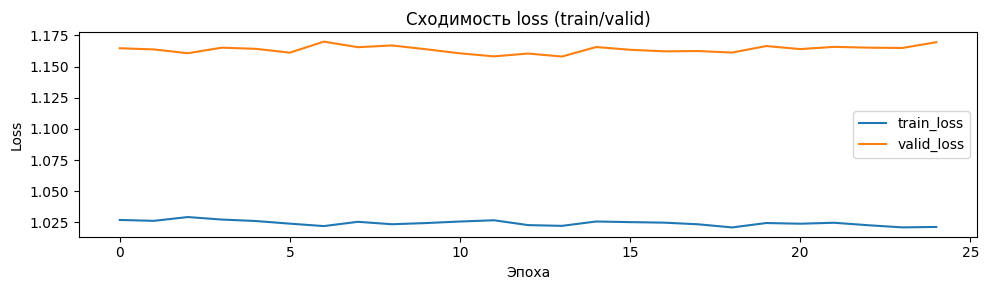

In [40]:
trainer_next.fit(train_loader, valid_loader, 25, plot=True)

In [41]:
for temp in [0.7, 1.0, 1.3]:
    print(f"\nTemperature = {temp}")
    for _ in range(5):
        print(model.generate_name(token2id, id2token,
                            start_text="", max_len=13,
                            temperature=temp))


Temperature = 0.7
erril
ort
illard
ernith
irtha

Temperature = 1.0
ola
ougia
ricia
aren
ilmadon

Temperature = 1.3
aremn
romara
rifth
ermen
uddet


## Прогноз пола

In [42]:
trainer_gender = NameTrainer(
    model,
    use_next_char_loss=False,
    use_gender_loss=True,
    alpha=0.0,
    beta=1.0,
)

Epoch 1:, gender_train=0.1417, gender_valid=0.6043
Epoch 10:, gender_train=0.1311, gender_valid=0.5750
Epoch 20:, gender_train=0.1171, gender_valid=0.6230
Epoch 25:, gender_train=0.1240, gender_valid=0.5944


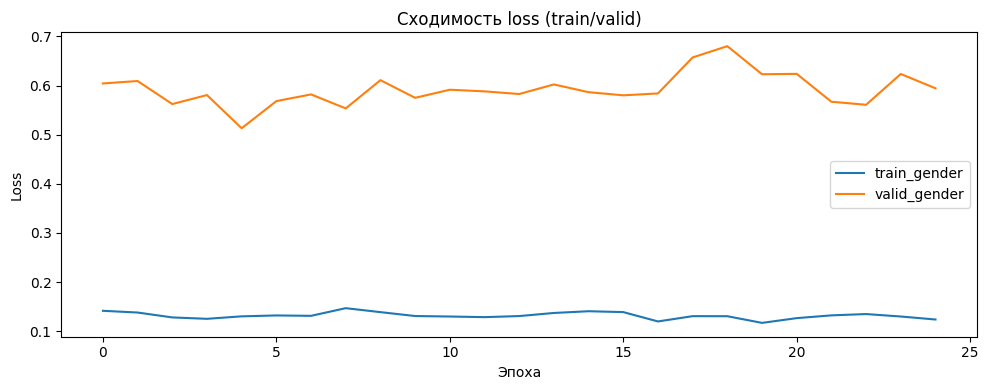

In [50]:
trainer_gender.fit(train_loader, valid_loader, 25, plot=True)

In [57]:
compute_roc_auc_splits(model, train_loader, valid_loader, test_loader)

train_roc_auc: 0.999
valid_roc_auc: 0.887
test_roc_auc:  0.906


# Gated Recurrent Unit (№5)

In [12]:
model = RecurrentModel(
    vocab_size=len(tokens),
    embedding_dim=64,
    hidden_size=128,
    rnn_block_cls=GRUBlock,
    dropout_p=0.1,
)

## Генерация имен

In [13]:
trainer_next = NameTrainer(
    model,
    use_next_char_loss=True,
    use_gender_loss=False,
    alpha=1.0,
    beta=0.0,
)

Epoch 1:next_train=1.7913, next_valid=1.4016
Epoch 10:next_train=1.1758, next_valid=1.1716
Epoch 20:next_train=1.0993, next_valid=1.1329
Epoch 25:next_train=1.0699, next_valid=1.1250


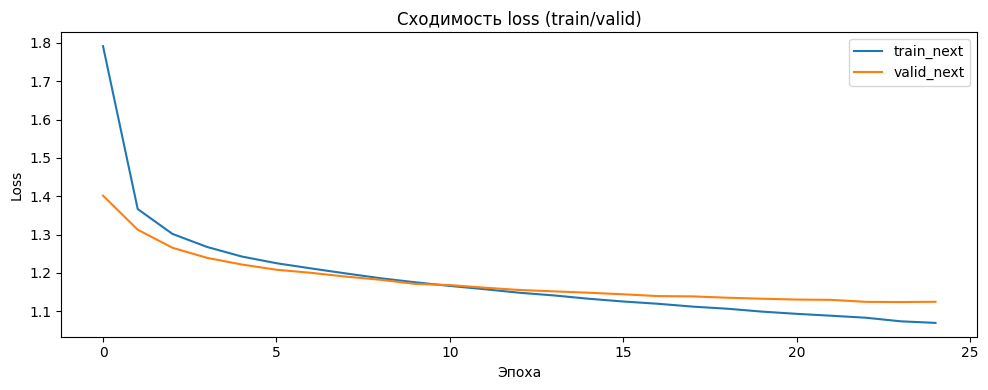

In [14]:
trainer_next.fit(train_loader, valid_loader, 25, plot=True)

In [15]:
for temp in [0.7, 1.0, 1.3]:
    print(f"\nTemperature = {temp}")
    for _ in range(5):
        print(model.generate_name(token2id, id2token,
                            start_text="", max_len=13,
                            temperature=temp))


Temperature = 0.7
andon
yanna
irta
harnon
adamen

Temperature = 1.0
hilla
anetha
uttie
eophoret
anara

Temperature = 1.3
irra
hardon
ara
larne
oto


## Прогноз пола

In [16]:
trainer_gender = NameTrainer(
    model,
    use_next_char_loss=False,
    use_gender_loss=True,
    alpha=0.0,
    beta=1.0,
)

Epoch 1:, gender_train=0.5027, gender_valid=0.4499
Epoch 10:, gender_train=0.1529, gender_valid=0.5115
Epoch 20:, gender_train=0.0658, gender_valid=0.7326
Epoch 25:, gender_train=0.0405, gender_valid=0.8959


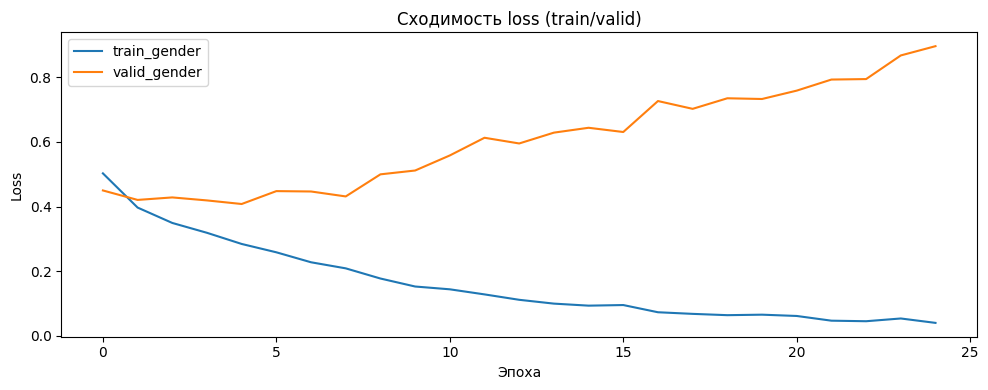

In [17]:
trainer_gender.fit(train_loader, valid_loader, 25, plot=True)

In [18]:
compute_roc_auc_splits(model, train_loader, valid_loader, test_loader)

train_roc_auc: 0.999
valid_roc_auc: 0.888
test_roc_auc:  0.901


# LSTM (№6)

In [24]:
model = RecurrentModel(
    vocab_size=len(tokens),
    embedding_dim=64,
    hidden_size=128,
    rnn_block_cls=LSTMBlock,
    dropout_p=0.1,
)

## Генерация имен

In [25]:
trainer_next = NameTrainer(
    model,
    use_next_char_loss=True,
    use_gender_loss=False,
    alpha=1.0,
    beta=0.0,
)

Epoch 1:next_train=1.8754, next_valid=1.4489
Epoch 10:next_train=1.1792, next_valid=1.1773
Epoch 20:next_train=1.1004, next_valid=1.1354
Epoch 25:next_train=1.0754, next_valid=1.1245


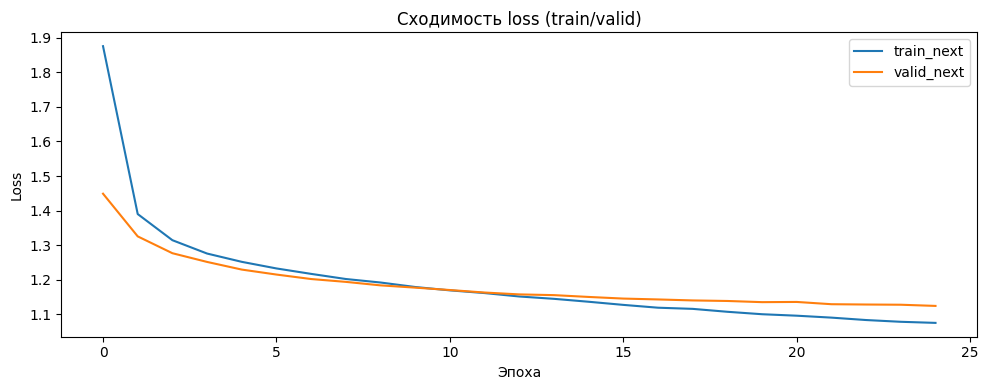

In [26]:
trainer_next.fit(train_loader, valid_loader, 25, plot=True)

In [28]:
for temp in [0.7, 1.0, 1.3]:
    print(f"\nTemperature = {temp}")
    for _ in range(5):
        print(model.generate_name(token2id, id2token,
                            start_text="", max_len=13,
                            temperature=temp))


Temperature = 0.7
annia
ada
alias
alah
ara

Temperature = 1.0
ark
edorah
jerelia
lena
trise

Temperature = 1.3
toney
amera
els
naka
paradrab


## Прогноз пола

In [29]:
trainer_gender = NameTrainer(
    model,
    use_next_char_loss=False,
    use_gender_loss=True,
    alpha=0.0,
    beta=1.0,
)

Epoch 1:, gender_train=0.5064, gender_valid=0.4531
Epoch 10:, gender_train=0.2049, gender_valid=0.4842
Epoch 20:, gender_train=0.0956, gender_valid=0.6458
Epoch 25:, gender_train=0.0709, gender_valid=0.6361


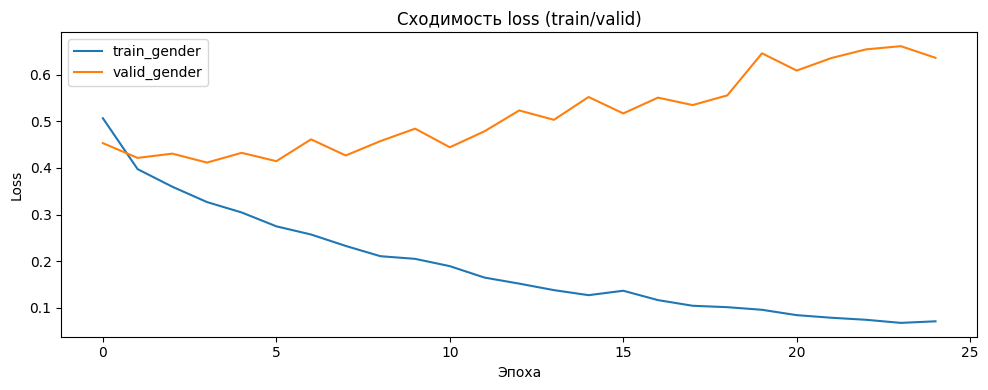

In [30]:
trainer_gender.fit(train_loader, valid_loader, 25, plot=True)

In [31]:
compute_roc_auc_splits(model, train_loader, valid_loader, test_loader)

train_roc_auc: 0.998
valid_roc_auc: 0.893
test_roc_auc:  0.917
